## Minería de Datos (Master en Data Science, UIMP-UC) 
## Tarea 1. Variables Categóricas: Reglas de Asociación y Árboles de Clasificación
### [Profesores: Sixto Herrera y Rodrigo García]

### Estudiante: Nicolò Trevisani


En la presente tarea consideraremos el dataset `Mushroom`, incluido tanto en la La librería [arulesViz](https://cran.r-project.org/web/packages/arulesViz/arulesViz.pdf) como en las diferentes plataformas descritas en el marco de la asignatura y en el GitHub dedicado a este Máster ([Mushroom](https://github.com/SantanderMetGroup/Master-Data-Science/blob/master/Data_mining/datasets/mushrooms.csv.)), para aplicar las diferentes técnicas vistas en el curso para variables categóricas: Reglas de Asociación y Árboles de Clasificación.

Para el desarrollo de la tarea se permitirá el uso de todo el material incluido en el Moodle de las asignatura así como el desarrollado por el alumno durante la realización de las prácticas.

La entrega consisitirá de un notebook de Jupyter ó un R-MarkDown, junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

### Punto 1 (3 puntos):

Considerar uno de los algoritmos de asociación vistos en clase y obtener las reglas representativas del dataset fijando los parámetros de aprendizaje (soporte, confianza, etc...). Analizar los resultados en términos generales:
* ¿Cuantas reglas se han generado?
* ¿Existe alguna regla redundante?, ¿Cuántas?
* ¿Existe alguna regla que incluya la variable objetivo: `Class=edible` ó `Class=poisonous`?, ¿Cuantas?
* De cara a ser utilizada como modelo predictivo es adecuado que la variable objetivo se encuentre en el consecuente de la regla de asociación, ¿se da esta propiedad en alguna regla?
* Considerar los subconjuntos de reglas con ambas clases como consecuente e ilustrar las variables implicadas en cada caso. Considerar alguno de los grafos vistos para apoyar las conclusiones obtenidas.

NOTA: Usar soportes superiores a 0.1 para evitar problemas de memoria.

## Desarrollo Punto 1

Cargo las librerias necesarias y el dataset

In [1]:
library(arulesViz)
library(arules)
#library(tidyverse)

data(Mushroom)
str(Mushroom)

head(Mushroom@itemInfo)

Loading required package: arules
Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write

Loading required package: grid
Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus


Formal class 'transactions' [package "arules"] with 3 slots
  ..@ data       :Formal class 'ngCMatrix' [package "Matrix"] with 5 slots
  .. .. ..@ i       : int [1:178360] 1 7 10 16 23 30 34 35 38 43 ...
  .. .. ..@ p       : int [1:8125] 0 22 45 68 90 112 135 158 180 202 ...
  .. .. ..@ Dim     : int [1:2] 114 8124
  .. .. ..@ Dimnames:List of 2
  .. .. .. ..$ : NULL
  .. .. .. ..$ : NULL
  .. .. ..@ factors : list()
  ..@ itemInfo   :'data.frame':	114 obs. of  3 variables:
  .. ..$ labels   : chr [1:114] "Class=edible" "Class=poisonous" "CapShape=bell" "CapShape=conical" ...
  .. ..$ variables: Factor w/ 23 levels "Bruises","CapColor",..: 5 5 3 3 3 3 3 3 4 4 ...
  .. ..$ levels   : Factor w/ 63 levels "almond","anise",..: 19 47 4 15 26 33 56 16 23 32 ...
  ..@ itemsetInfo:'data.frame':	8124 obs. of  0 variables


labels,variables,levels
<chr>,<fct>,<fct>
Class=edible,Class,edible
Class=poisonous,Class,poisonous
CapShape=bell,CapShape,bell
CapShape=conical,CapShape,conical
CapShape=flat,CapShape,flat
CapShape=knobbed,CapShape,knobbed


Imprimo un pequeño resumen de las variables disponibles y de sus posibles valores.

In [2]:
for (variable in levels(Mushroom@itemInfo$variables)){
    print(variable)
    for (level in levels(Mushroom@itemInfo$levels)){
        for (label in Mushroom@itemInfo$labels){
            if (grepl(variable, label) & grepl(level, label))
            print(paste("    ",level))
        }
    }
}

[1] "Bruises"
[1] "     bruises"
[1] "     no"
[1] "CapColor"
[1] "     brown"
[1] "     buff"
[1] "     cinnamon"
[1] "     gray"
[1] "     green"
[1] "     pink"
[1] "     purple"
[1] "     red"
[1] "     white"
[1] "     yellow"
[1] "CapShape"
[1] "     bell"
[1] "     conical"
[1] "     convex"
[1] "     flat"
[1] "     knobbed"
[1] "     no"
[1] "     sunken"
[1] "CapSurf"
[1] "     fibrous"
[1] "     grooves"
[1] "     scaly"
[1] "     smooth"
[1] "Class"
[1] "     edible"
[1] "     no"
[1] "     poisonous"
[1] "ColorAboveRing"
[1] "     brown"
[1] "     buff"
[1] "     cinnamon"
[1] "     gray"
[1] "     orange"
[1] "     pink"
[1] "     red"
[1] "     white"
[1] "     yellow"
[1] "ColorBelowRing"
[1] "     brown"
[1] "     buff"
[1] "     cinnamon"
[1] "     gray"
[1] "     orange"
[1] "     pink"
[1] "     red"
[1] "     white"
[1] "     yellow"
[1] "GillAttached"
[1] "     attached"
[1] "     free"
[1] "GillColor"
[1] "     black"
[1] "     brown"
[1] "     buff"
[1] "     ch

In [3]:
head(Mushroom)
print("----------------------")

transactions in sparse format with
 6 transactions (rows) and
 114 items (columns)

[1] "----------------------"


Transformo el dataset en un objeto *transactions* de arules

In [4]:
transactions <- as(Mushroom, "transactions")
transactions
print("----------------------")

transactions in sparse format with
 8124 transactions (rows) and
 114 items (columns)

[1] "----------------------"


Creo las reglas de asociación utilizando el metodo apriori, como implementado en la libreria arules.

Uso las siguientes restricciones para las reglas generadas:
- soporte (relativo) mínimo: 0.1;
- longitud mínima: 2;
- longitud máxima: 20.

In [5]:
rApriori <- apriori(transactions, parameter = list(support = 0.1, minlen = 2, maxlen = 20))
print("----------------------")

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.1      2
 maxlen target   ext
     20  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 812 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[114 item(s), 8124 transaction(s)] done [0.02s].
sorting and recoding items ... [53 item(s)] done [0.00s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 11 12 13

Warning message in apriori(transactions, parameter = list(support = 0.1, minlen = 2, :
“Mining stopped (time limit reached). Only patterns up to a length of 13 returned!”

 done [5.09s].
writing ... [2549050 rule(s)] done [0.67s].
creating S4 object  ... done [1.47s].
[1] "----------------------"


In [6]:
iEclat <- eclat(transactions, parameter = list(support = 0.1, minlen = 2, maxlen = 20))
rEclat <- ruleInduction(iEclat, transactions, confidence = 0)

Eclat

parameter specification:
 tidLists support minlen maxlen            target   ext
    FALSE     0.1      2     20 frequent itemsets FALSE

algorithmic control:
 sparse sort verbose
      7   -2    TRUE

Absolute minimum support count: 812 

create itemset ... 
set transactions ...[114 item(s), 8124 transaction(s)] done [0.02s].
sorting and recoding items ... [53 item(s)] done [0.00s].
creating bit matrix ... [53 row(s), 8124 column(s)] done [0.00s].
writing  ... [379492 set(s)] done [0.17s].
Creating S4 object  ... done [0.11s].


Mirando al resumen del objeto rApriori, donde se guardan todas las reglas de acociación generadas, se observa que estas son:
- 2560630 en el caso apriori;
- 2995184 en el caso eclat;

In [7]:
summary(rApriori)
print("----------------------")

summary(rEclat)
print("----------------------")

set of 2549050 rules

rule length distribution (lhs + rhs):sizes
     2      3      4      5      6      7      8      9     10     11     12 
   331   4862  29136  99724 228717 384061 495449 501329 399135 247755 117473 
    13 
 41078 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   7.000   9.000   8.563  10.000  13.000 

summary of quality measures:
    support         confidence          lift            count     
 Min.   :0.1002   Min.   :0.8000   Min.   :0.8266   Min.   : 814  
 1st Qu.:0.1064   1st Qu.:1.0000   1st Qu.:1.0849   1st Qu.: 864  
 Median :0.1064   Median :1.0000   Median :1.6459   Median : 864  
 Mean   :0.1263   Mean   :0.9897   Mean   :1.7508   Mean   :1026  
 3rd Qu.:0.1241   3rd Qu.:1.0000   3rd Qu.:2.1515   3rd Qu.:1008  
 Max.   :0.9754   Max.   :1.0000   Max.   :6.8718   Max.   :7924  

mining info:
         data ntransactions support confidence
 transactions          8124     0.1        0.8

[1] "----------------------"


set of 2995184 rules

rule length distribution (lhs + rhs):sizes
     2      3      4      5      6      7      8      9     10     11     12 
  1376  11835  52436 147540 297354 460873 568128 560862 440150 270556 127356 
    13     14     15     16 
 44291  10710   1605    112 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   7.000   8.000   8.429  10.000  16.000 

summary of quality measures:
    support         confidence          lift           itemset      
 Min.   :0.1002   Min.   :0.1019   Min.   :0.3794   Min.   :     1  
 1st Qu.:0.1064   1st Qu.:0.9818   1st Qu.:1.0849   1st Qu.: 96553  
 Median :0.1064   Median :1.0000   Median :1.6014   Median :189540  
 Mean   :0.1253   Mean   :0.9238   Mean   :1.7232   Mean   :188140  
 3rd Qu.:0.1182   3rd Qu.:1.0000   3rd Qu.:2.0746   3rd Qu.:280433  
 Max.   :0.9754   Max.   :1.0000   Max.   :6.8718   Max.   :379492  

mining info:
         data ntransactions support confidence
 transactions          8124     0.1          0

[1] "----------------------"


Dos reglas se dicen redundantes (entre si) cuando aportan la misma información.

Más en detalle, dos reglas se consideran redundantes si:
- involucran los mismos items, que pero aparecen con distintos roles (antecedente y consecuente);
- tienen la misma confianza y el mismo lift.

Podemos encontrar las reglas redundantes con el comando *is.redundant* de r.

In [8]:
# Algoritmo apriori
indRedundant.apriori <- which(is.redundant(rApriori))
length(indRedundant.apriori)
length(indRedundant.apriori) / length(rApriori) #2560630
length(rApriori) - length(indRedundant.apriori)

# Algoritmo eclat
indRedundant.eclat <- which(is.redundant(rEclat))
length(indRedundant.eclat)
length(indRedundant.eclat) / length(rEclat) #2995184
length(rEclat) - length(indRedundant.eclat)

[1] 2541070

[1] 0.9968694

[1] 7980

[1] 2977548

[1] 0.9941119

[1] 17636

La casi totalidad de la reglas de asociación resulta ser redundante:
- 2552650 de 2560630 (99.7 %) en el caso apriori;
- 2977548 de 2995184 (99.4 %) en el caso eclat.

Podemos quedarnos con la pequeña fracción de reglas no redundantes:
- 7980 en el caso apriori;
- 17636 en el caso eclat.

In [9]:
rAprioriFiltered <- rApriori[!is.redundant(rApriori)]
rAprioriFiltered

rEclatFiltered <- rEclat[!is.redundant(rEclat)]
rEclatFiltered

set of 7980 rules 

set of 17636 rules 

De esas, las que involucran la variable "Class=poisonus", son:
- 183 para el metodo apriori como consecuente;
- 577 para el metodo apriori como antecedente;
- 299 para el metodo eclat como consecuente;
- 1297 para el metodo eclat como antecedente;

In [10]:
rhs.poisonous.apriori <- subset(rAprioriFiltered, subset = rhs %in% c("Class=poisonous"))
length(subset(rAprioriFiltered, subset = rhs %in% c("Class=poisonous")))

[1] 183

In [11]:
length(subset(rAprioriFiltered, subset = lhs %in% c("Class=poisonous")))

[1] 577

In [12]:
rhs.poisonous.eclat <- subset(rEclatFiltered, subset = rhs %in% c("Class=poisonous"))
length(subset(rEclatFiltered, subset = rhs %in% c("Class=poisonous")))

[1] 299

In [13]:
length(subset(rEclatFiltered, subset = lhs %in% c("Class=poisonous")))

[1] 1297

De esas, las que involucran la variable "Class=edible", son:
- 353 para el metodo apriori como consecuente;
- 1355 para el metodo apriori como antecedente;
- 458 para el metodo eclat como consecuente;
- 3013 para el metodo eclat como antecedente;

In [14]:
rhs.edible.apriori <- subset(rAprioriFiltered, subset = rhs %in% c("Class=edible"))
length(subset(rAprioriFiltered, subset = rhs %in% c("Class=edible")))

[1] 353

In [15]:
length(subset(rAprioriFiltered, subset = lhs %in% c("Class=edible")))

[1] 1355

In [16]:
rhs.edible.eclat <- subset(rEclatFiltered, subset = rhs %in% c("Class=edible"))
length(subset(rEclatFiltered, subset = rhs %in% c("Class=edible")))

[1] 458

In [17]:
length(subset(rEclatFiltered, subset = lhs %in% c("Class=edible")))

[1] 3013

Inspeccionamos ahora más en detalle los subconjuntos de reglas que tengan las dos clases objetivo como consecuente:
- Class=edible;
- Class=poisonous.

In [18]:
inspect(head(sort(rhs.edible.apriori, by ="lift"),10))

     lhs                      rhs              support confidence     lift count
[1]  {GillSize=broad,                                                           
      GillColor=brown}     => {Class=edible} 0.1083210          1 1.930608   880
[2]  {Odor=none,                                                                
      StalkRoot=equal}     => {Class=edible} 0.1063516          1 1.930608   864
[3]  {Bruises=no,                                                               
      StalkRoot=equal}     => {Class=edible} 0.1063516          1 1.930608   864
[4]  {GillSpace=crowded,                                                        
      Habitat=grasses}     => {Class=edible} 0.1299852          1 1.930608  1056
[5]  {GillSpace=crowded,                                                        
      StalkShape=tapering} => {Class=edible} 0.1063516          1 1.930608   864
[6]  {GillSpace=crowded,                                                        
      GillSize=broad}      =

In [19]:
inspect(head(sort(rhs.poisonous.apriori, by ="lift"),10))

     lhs                         rhs                 support confidence     lift count
[1]  {RingType=large}         => {Class=poisonous} 0.1595273          1 2.074566  1296
[2]  {GillColor=buff}         => {Class=poisonous} 0.2127031          1 2.074566  1728
[3]  {Odor=foul}              => {Class=poisonous} 0.2658789          1 2.074566  2160
[4]  {CapColor=red,                                                                   
      GillSize=narrow}        => {Class=poisonous} 0.1063516          1 2.074566   864
[5]  {CapColor=red,                                                                   
      Bruises=no}             => {Class=poisonous} 0.1078287          1 2.074566   876
[6]  {SurfaceBelowRing=silky,                                                         
      Spore=chocolate}        => {Class=poisonous} 0.1595273          1 2.074566  1296
[7]  {SurfaceAboveRing=silky,                                                         
      Spore=chocolate}        => {Class=poi

Mirando a los plots de confianza, soporte y lift, parece que confianza y lift, en este caso, son correlacionados (alta confianza ~ alto lift).

Nos podemos quedar entonces con as reglas de asociación más interesante requierendo que la confianza sea alta. 

De esta manera, va a ser posible dibujar grafos con flechas que enseñen cuales son las variables más importantes para identificar si una seta es comestible o venenosa, sin que estos sean demasiado cargados de información.

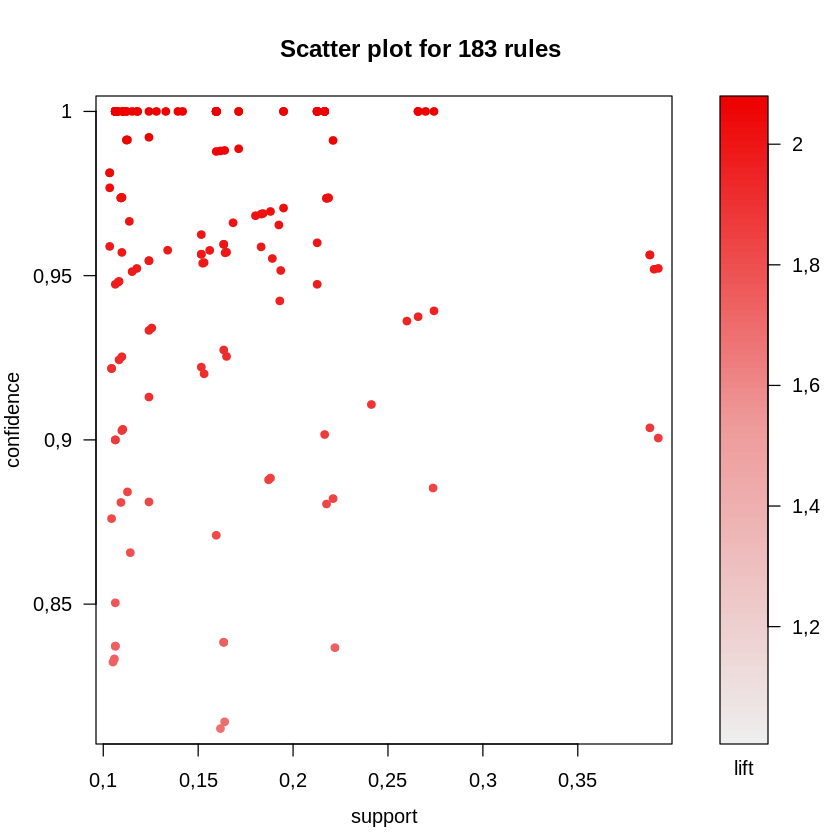

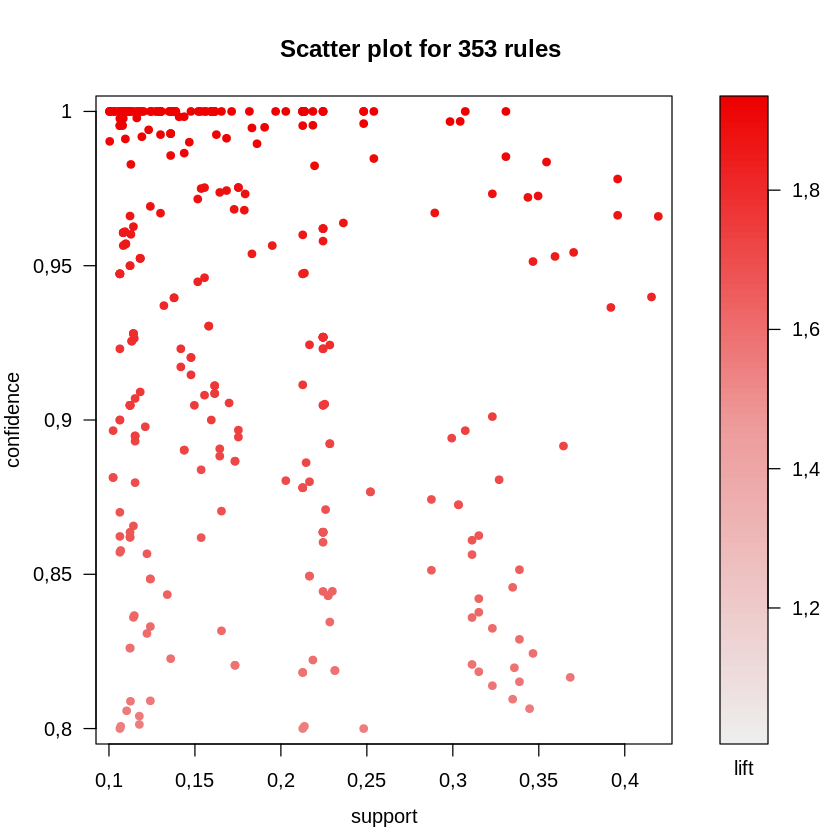

In [20]:
par(mfrow=c(1,2)) 

plot.1 <- plot(rhs.poisonous.apriori, jitter = 0)
plot.2 <- plot(rhs.edible.apriori, jitter = 0)

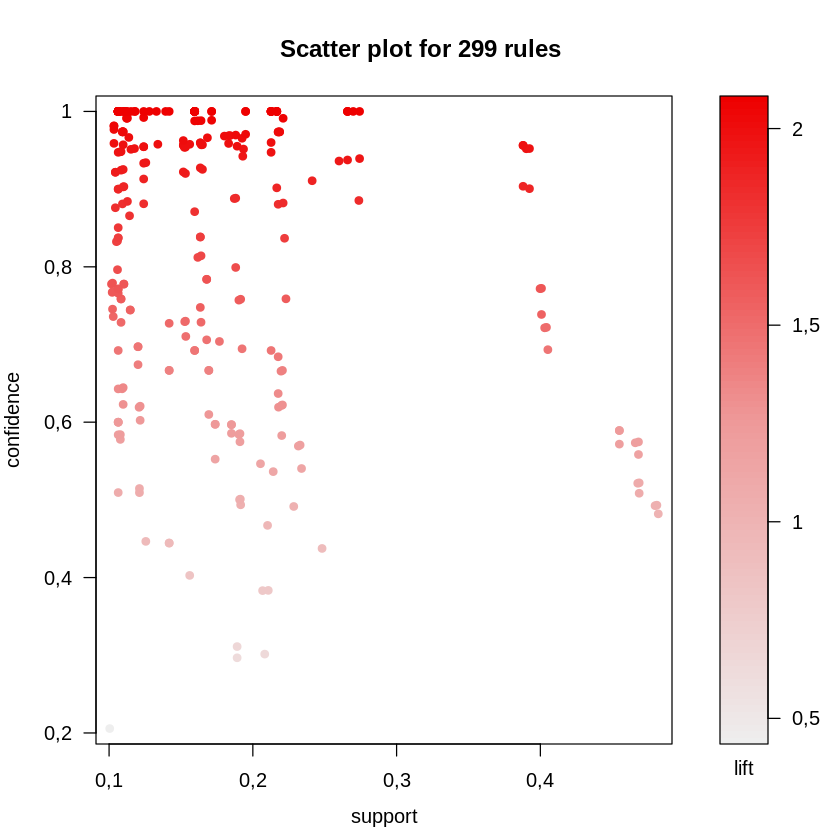

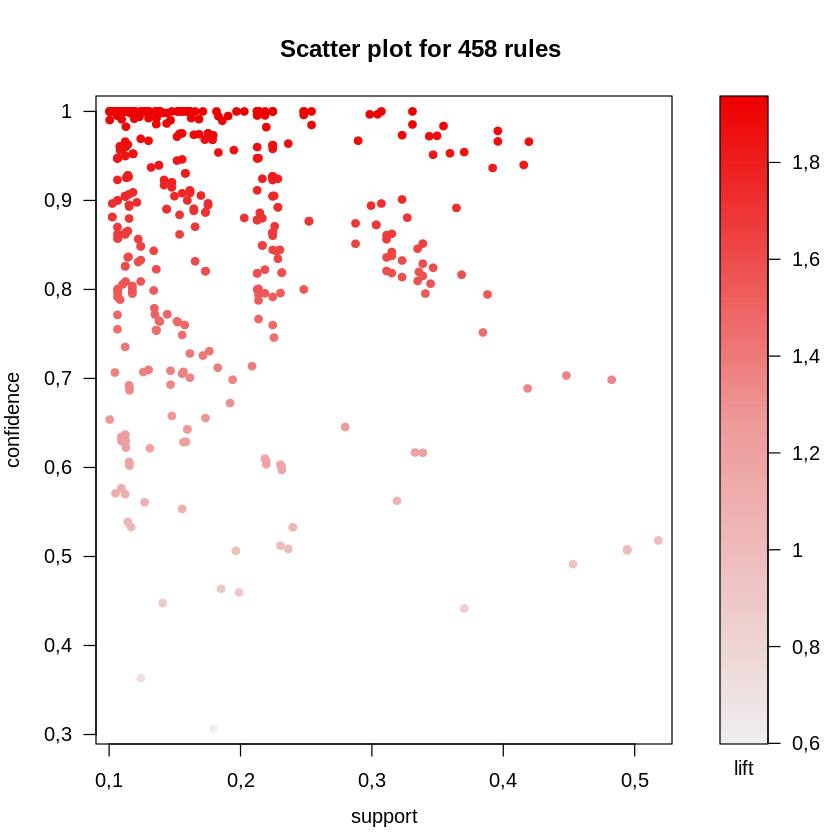

In [21]:
par(mfrow=c(1,2)) 

plot.3 <- plot(rhs.poisonous.eclat, jitter = 0)
plot.4 <- plot(rhs.edible.eclat, jitter = 0)

Seleccionando solo las reglas con alta confianza y subiendo ligeramente el soporte minimo, logramos obtener las reglas más fiables para distinguir setas:
- rojo más fuerte: seta venenosa;
- rojo más suave: seta comestible.

Se puede observar en el grafo de abajo que las reglas que apuntan a clases distintas, tipicamente no tienen variables en común, como hay que esperar si las reglas son fiables.

Además, cuando las mismas variables (e.g. SurfaceAboveRing) aparecen en reglas para seleccionar setas venenosas o comestibles, lo hacen con valores distintos:
- SurfaceAboveRing = silky --> venenoso;
- SurfaceAboveRing = smooth --> comestible.

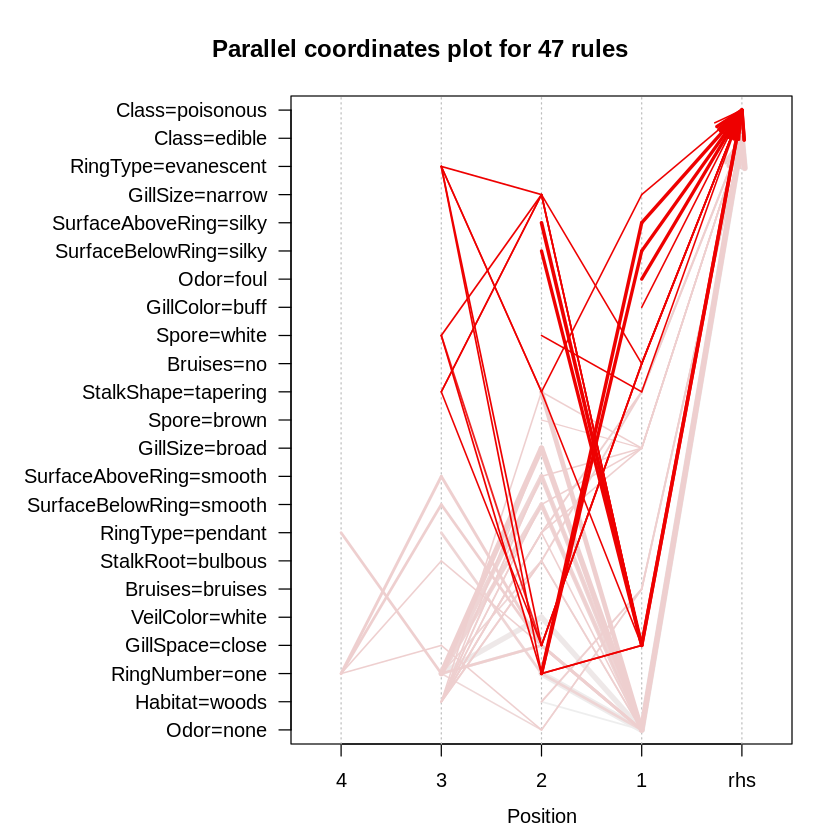

In [22]:
rAprioriClasses <- subset(rAprioriFiltered, subset = rhs %in% c("Class=edible") | rhs %in% c("Class=poisonous"))

rApriori.high.conf <- subset(rAprioriClasses, subset = confidence > 0.98 & support > 0.2)
#rApriori.high.conf <- subset(rAprioriClasses, subset = confidence > 0.98 & support > 0.25)
plot(rApriori.high.conf, method="paracoord")

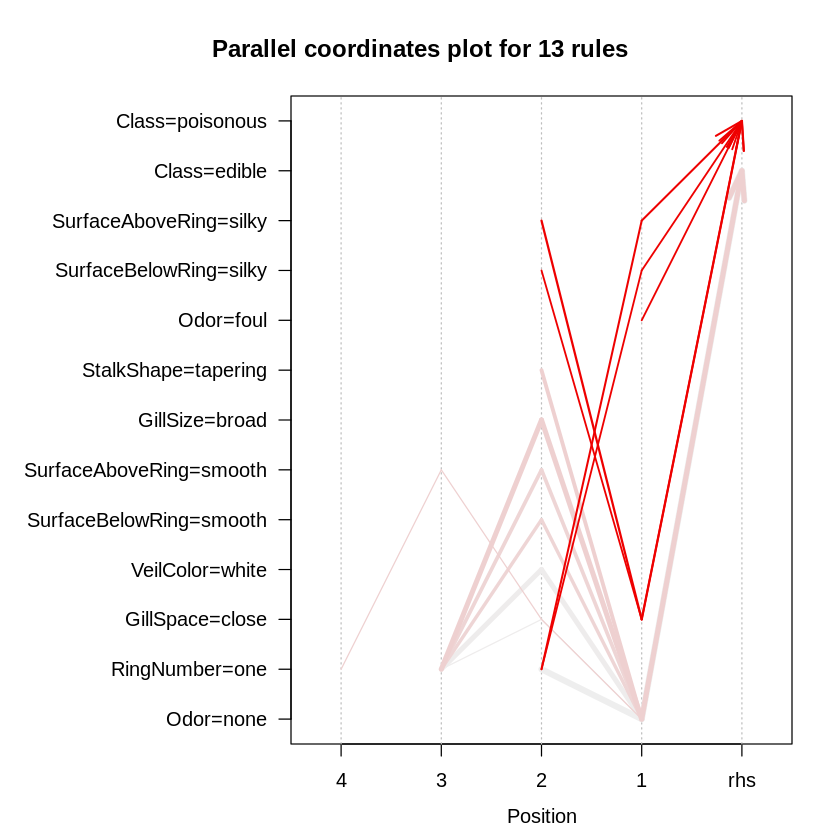

In [23]:
rEclatClasses <- subset(rEclatFiltered, subset = rhs %in% c("Class=edible") | rhs %in% c("Class=poisonous"))

#rEclat.high.conf <- subset(rEclatClasses, subset = confidence > 0.98 & support > 0.2)
rEclat.high.conf <- subset(rEclatClasses, subset = confidence > 0.98 & support > 0.25)
plot(rEclat.high.conf, method="paracoord")

### Punto 2 (4 puntos):

En este apartado aplicaremos árboles de clasificación para obtener un modelo que permita clasificar una nueva entrada. Para ello, vamos a utilizaremos el paquete `CaReT`. Este paquete (y los demás que hemos visto para trabajar con árboles en `R`) no aceptan objetos del tipo `transactions` como los del apartado anterior. Por tanto, hemos preparado un fichero *csv* con el dataset *Mushrooms*; puedes descargarlo desde esta aquí:
https://github.com/SantanderMetGroup/Master-Data-Science/tree/master/Data_mining/datasets. Lee el dataset con la función `read.csv`.  
Ahora ya tenemos un data.frame con el que podemos empezar a trabajar. En primer lugar tendremos que eliminar la columna 17 (`veil.type`), ya que contiene un único nivel y daría errores en `CaReT`(esta columna podría eliminarse también en el caso de las reglas de asociación ya que no aporta información al dataset).  
Nuestro objetivo será encontrar la configuración (profundidad) óptima del árbol. Para ello, partiremos el dataset en dos subconjuntos indpendedientes de train y test (75% y 25% del total, respectivamente). Sobre el dataset de train, aplicaremos una cross-validación con 3 folds y la repetiremos 50 veces (recuerda que los árboles son sensibles a la partición train/test que se considere). 

* ¿Cuál es la configuración óptima del árbol? ¿Hay alguna diferencia entre el árbol *completo* y el óptimo? ¿Por qué crees que ocurre esto?
* ¿Cuáles son las dos variables que mayor peso tienen a la hora de clasificar? Entrena un nuevo árbol considerando como predictores únicamente esas dos variables. ¿Qué resultados obtienes? 
* Entrena un nuevo árbol considerando como predictores cualesquiera otras dos variables que no sean las utilizadas en la pregunta anterior. ¿Cuál es el error de test de este árbol?

## Desarrollo Punto 2

Cargo la libreria CaReT y el dataset en formato csv.

In [1]:
library(caret)

mushrooms <- read.csv("mushrooms.csv")

# Elimino la columna 17 (veil.type)
mushrooms <- mushrooms[,-17]
str(mushrooms)

nrow(mushrooms)

Loading required package: lattice
Loading required package: ggplot2


'data.frame':	8124 obs. of  22 variables:
 $ class                   : Factor w/ 2 levels "e","p": 2 1 1 2 1 1 1 1 2 1 ...
 $ cap.shape               : Factor w/ 6 levels "b","c","f","k",..: 6 6 1 6 6 6 1 1 6 1 ...
 $ cap.surface             : Factor w/ 4 levels "f","g","s","y": 3 3 3 4 3 4 3 4 4 3 ...
 $ cap.color               : Factor w/ 10 levels "b","c","e","g",..: 5 10 9 9 4 10 9 9 9 10 ...
 $ bruises                 : Factor w/ 2 levels "f","t": 2 2 2 2 1 2 2 2 2 2 ...
 $ odor                    : Factor w/ 9 levels "a","c","f","l",..: 7 1 4 7 6 1 1 4 7 1 ...
 $ gill.attachment         : Factor w/ 2 levels "a","f": 2 2 2 2 2 2 2 2 2 2 ...
 $ gill.spacing            : Factor w/ 2 levels "c","w": 1 1 1 1 2 1 1 1 1 1 ...
 $ gill.size               : Factor w/ 2 levels "b","n": 2 1 1 2 1 1 1 1 2 1 ...
 $ gill.color              : Factor w/ 12 levels "b","e","g","h",..: 5 5 6 6 5 6 3 6 8 3 ...
 $ stalk.shape             : Factor w/ 2 levels "e","t": 1 1 1 1 2 1 1 1 1 1 ...
 $ stalk.r

[1] 8124

Separo el dataset en dos partes:
- Train (75%);
- Test (25%).

In [75]:
n = nrow(mushrooms)
n

indtrain = sample(1:n, 0.75*n)

mushrooms.train = mushrooms[indtrain, ]
mushrooms.test = mushrooms[-indtrain, ]

nrow(mushrooms.train)
nrow(mushrooms.test)

head(mushrooms.test)
head(mushrooms.train)

[1] 8124

[1] 6093

[1] 2031

,class,cap.shape,cap.surface,cap.color,bruises,odor,gill.attachment,gill.spacing,gill.size,gill.color,⋯,stalk.surface.above.ring,stalk.surface.below.ring,stalk.color.above.ring,stalk.color.below.ring,veil.color,ring.number,ring.type,spore.print.color,population,habitat
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,p,x,s,n,t,p,f,c,n,k,⋯,s,s,w,w,w,o,p,k,s,u
2,e,x,s,y,t,a,f,c,b,k,⋯,s,s,w,w,w,o,p,n,n,g
11,e,x,y,y,t,l,f,c,b,g,⋯,s,s,w,w,w,o,p,n,n,g
13,e,b,s,y,t,a,f,c,b,w,⋯,s,s,w,w,w,o,p,n,s,g
16,e,s,f,g,f,n,f,c,n,k,⋯,s,s,w,w,w,o,p,n,y,u
21,e,b,s,y,t,a,f,c,b,k,⋯,s,s,w,w,w,o,p,n,s,m


,class,cap.shape,cap.surface,cap.color,bruises,odor,gill.attachment,gill.spacing,gill.size,gill.color,⋯,stalk.surface.above.ring,stalk.surface.below.ring,stalk.color.above.ring,stalk.color.below.ring,veil.color,ring.number,ring.type,spore.print.color,population,habitat
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
7881,p,k,s,n,f,s,f,c,n,b,⋯,k,k,w,w,w,o,e,w,v,d
3759,p,f,f,y,f,f,f,c,b,p,⋯,k,k,b,p,w,o,l,h,y,p
4356,p,f,y,g,f,f,f,c,b,h,⋯,k,k,n,n,w,o,l,h,y,g
5728,e,f,f,n,f,n,f,w,n,w,⋯,f,s,w,n,w,o,e,w,v,l
5229,p,x,s,b,t,f,f,c,b,w,⋯,s,s,w,w,w,o,p,h,s,u
2151,e,x,f,e,t,n,f,c,b,u,⋯,s,s,g,p,w,o,p,k,y,d


### Entrenamiento con validación cruzada

Preparo el entrenamiento con validación cruzada:
- la muestra de entrenamiento se separa en 3 sub-muestras utilizadas para una validación 3-fold;
- la validación 3-fold se ejecuta 50 veces, extrayendo cada vez 3 sub-muestras distintas;
- se deja variar la profundidad del arbol entre 1 y 15, para encontrar la configuración optima.

Los resultados enseñan que a partir de una profundidad de 6, la *accuracy* del arbol no mejora, llegando a saturar a $\sim$ 0.98.

Se nota además que la accuracy medida en la muestra de entrenamiento y la medida en la muestra de test tienen valores muy parecidos.

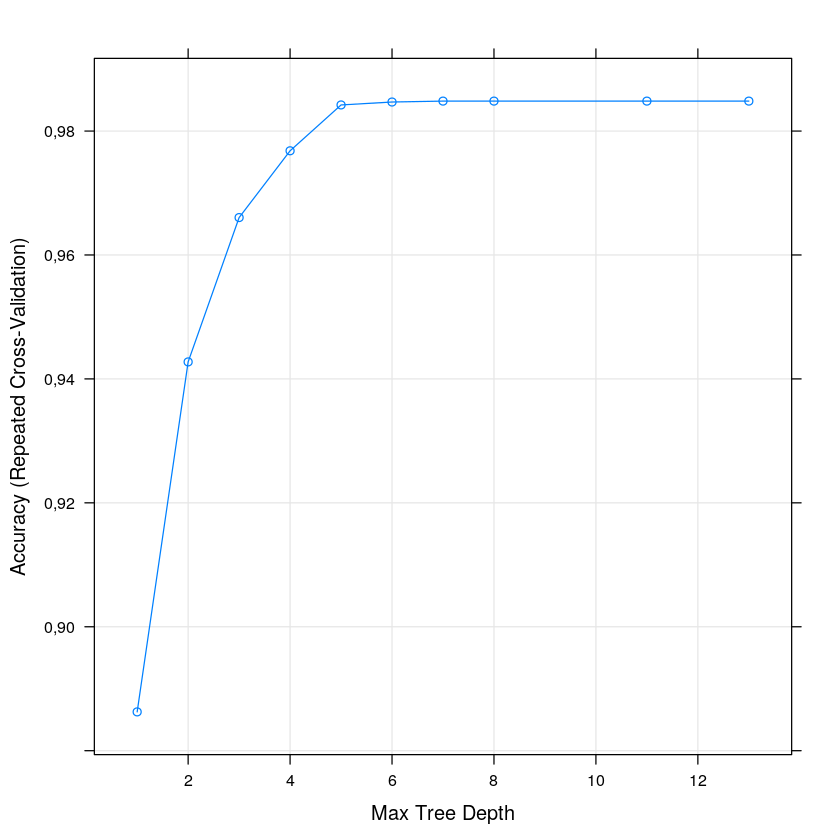

In [54]:
trainCV <- trainControl(method = "repeatedcv",
                        ## 3-fold CV
                        number = 3,
                        ## repeated 50 times
                        repeats = 50)

my.train <- train(class ~ ., data = mushrooms.train, 
                 method = "rpart2", 
                 trControl = trainCV,
                 # test tree depth in 1:10
                 tuneLength = 10)


plot(my.train)

odorn                     odorf               stalk.rootc 
               1870,89352                 594,93144                 536,97304 
stalk.surface.below.ringk                gill.sizen stalk.surface.above.ringk 
                527,18124                 514,47808                 514,47808 
            gill.spacingw                  habitatm               stalk.rootr 
                503,89211                 306,61652                 253,24502 
stalk.surface.below.ringy               populationn                     odorl 
                253,24502                 251,99472                 241,71964 
       spore.print.colorr               gill.colork               gill.colorr 
                106,28029                  60,68983                  36,05939 
                    odorm 
                 34,30295

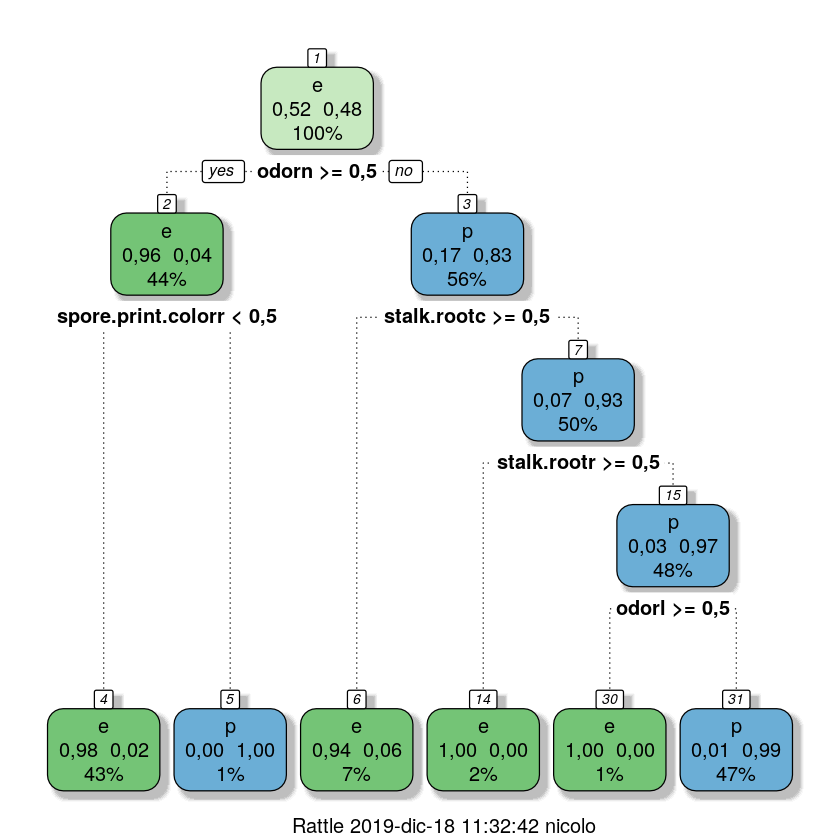

In [55]:
library(rattle)
fancyRpartPlot(my.train$finalModel)

sort(my.train$finalModel$variable.importance, decreasing = T)

In [87]:
pred.train = predict(my.train, newdata = mushrooms.train)
print("Accuracy medida en la muestra de entrenamiento:")
sum(diag(table(pred.train, mushrooms.train$class))) / dim(mushrooms.train)[1]

pred.test = predict(my.train, newdata = mushrooms.test)
print("Accuracy medida en la muestra de test:")
sum(diag(table(pred.test, mushrooms.test$class))) / dim(mushrooms.test)[1]

table(pred.test, mushrooms.test$class)
table(pred.train, mushrooms.train$class)

[1] "Accuracy medida en la muestra de entrenamiento:"


[1] 0,9837518

[1] "Accuracy medida en la muestra de test:"


[1] 0,9837518

         
pred.test    e    p
        e 1073   24
        p    9  925

          
pred.train    e    p
         e 3087   60
         p   39 2907

### Entrenamiento sin poner limites a la profundidad del arbol

Al intentar usar *caret* para dejar crecer un arbol hasta la máxima profundidad posible, se genera otro arbol igual que el arbol 'optimo'.
Eso puede ser debido a que el arbol 'optimo' ya tiene profundidad suficiente y el algoritmo decide parar el crecimiento del arbol, no encontrando mejoras significativas en el entropia de los nodos al crear otras ramas.

Para forzar el entrenamiento hasta la clasificación perfecta, se puede usar la libreria *tree*, imponendo las siguientes opciones de entrenamiento:
- mindev = 0 (mínima desviación aceptada en una hoja); 
- minsize = 2 (mínimo número de eventos en un nudo para que pueda originar otra biforcación).

En ambos casos, la variable que más discriminación proporciona, con diferencia, es:
- odor.

En el caso de *tree*, la segunda es:
- spore.print.color.

En este caso particular (dataset mushrooms), dejar crecer el arbol parece no tener un efecto significativo sobre su generalización.
En particular, se observa que la *accuracy*, tanto cuando se mide en la muestra de entrenamiento, cuanto en la muestra de test, sigue dando valores muy altos ($\sim$ 98% - 99% en el caso de caret, 100% en el caso de tree).

Esto parece ser debido al hecho que las dos variables principales son capaces de distinguir de manera muy efectiva entre las dos categorias de setas (comestible y venenosa), como se observa en las representaciones gráficas de los arboles (tanto en el que se ha entrenado usando *tree* como en el que se ha entrenado usando *caret*).

Dicho de otra forma, las reglas para distinguir setas comestible y setas venenosas se basan en dos variables: añadiendo más información los resultados cambian muy poco, y esto nos "protege" del sobreajuste.

Por otro lado, el perfecto ajuste en el caso de la muestra de test para el arbol entrenado con tree, sugiere que:
- las muestras de entrenamiento y de test son muy parecidas;
- el arbol no llega a una profundidad tan grande como para verdaderamente ser sobreajustado (el árbol de caret tiene 6 hojas, el arbol de tree solo dos más).

#### Caret

note: only 8 possible values of the max tree depth from the initial fit.
 Truncating the grid to 8 .



odorn                     odorf               stalk.rootc 
               1899,66566                 582,45828                 520,77076 
               gill.sizen stalk.surface.above.ringk stalk.surface.below.ringk 
                508,11726                 503,78671                 503,78671 
               ring.typep                  habitatm               stalk.rootr 
                492,23859                 284,24672                 263,02586 
stalk.surface.below.ringy               populationn                     odorl 
                263,02586                 243,20259                 190,95071 
       spore.print.colorr                     odorc                  bruisest 
                106,74250                  75,19750                  74,33557 
             stalk.shapet               gill.colork             gill.spacingw 
                 74,33557                  71,37467                  64,21405 
               cap.colory                cap.shapef                cap.shapex 
                 40,83221                  38,73826                  38,73826 
              gill.colorr                     odorm        spore.print.coloru 
                 36,21621                  34,36558                  13,79094 
               cap.colorp 
                  1,29290

[1] "Accuracy medida en la muestra de entrenamiento:"


[1] 0,9901526

[1] "Accuracy medida en la muestra de test:"


[1] 0,9881832

               
pred.caret.test    e    p
              e 1082   24
              p    0  925

                
pred.caret.train    e    p
               e 3126   60
               p    0 2907

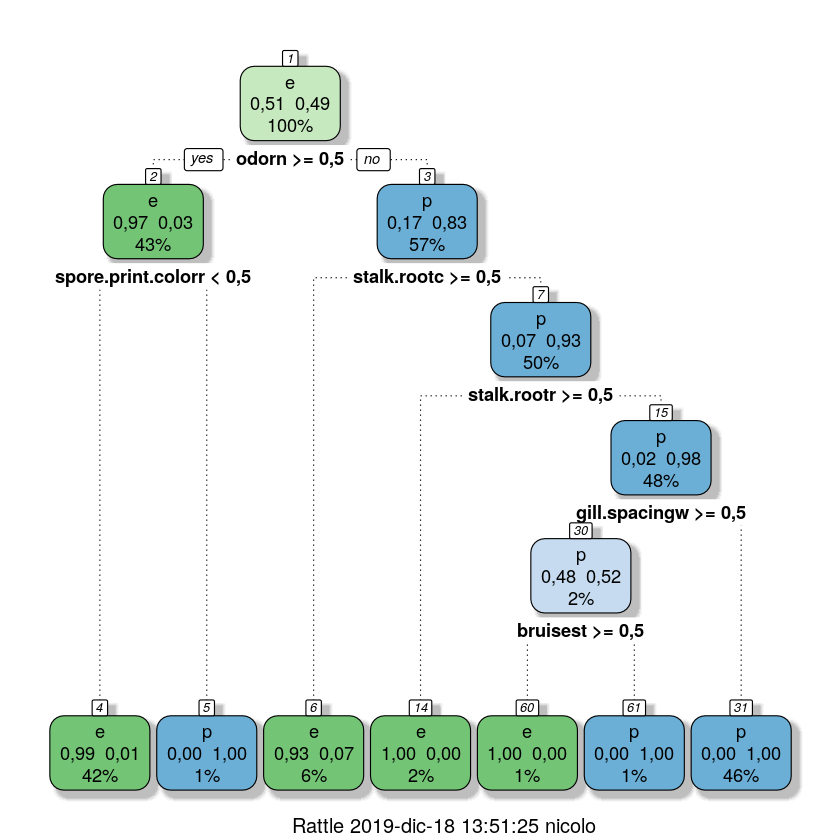

In [86]:
t.caret <- train(class ~ ., data = mushrooms.train, 
                 method = "rpart2",
                 tuneLength = 10)
                 
fancyRpartPlot(t.caret$finalModel)

sort(t.caret$finalModel$variable.importance, decreasing = T)

pred.caret.train = predict(t.caret, newdata = mushrooms.train)
print("Accuracy medida en la muestra de entrenamiento:")
sum(diag(table(pred.caret.train, mushrooms.train$class))) / dim(mushrooms.train)[1]

pred.caret.test = predict(t.caret, newdata = mushrooms.test)
print("Accuracy medida en la muestra de test:")
sum(diag(table(pred.caret.test, mushrooms.test$class))) / dim(mushrooms.test)[1]

table(pred.caret.test, mushrooms.test$class)
table(pred.caret.train, mushrooms.train$class)

#### tree

,var,n,dev,yval,splits,yprob
,<fct>,<dbl>,<dbl>,<fct>,"<chr[,2]>","<dbl[,2]>"
1,odor,6093,"8439,38317",e,":adf , :bceghi","0,5173150, 0,482685048"
2,spore.print.color,3248,"865,25192",e,":abcdeghi, :f","0,9704433, 0,029556650"
4,stalk.color.below.ring,3192,"429,85852",e,":cdfgh , :ei","0,9874687, 0,012531328"
8,cap.surface,3117,"111,42241",e,":acd , :b","0,9974334, 0,002566570"
16,habitat,3113,"61,25124",e,":abdefg , :c","0,9987151, 0,001284934"
32,<leaf>,2967,"0,00000",e,",","1,0000000, 0,000000000"
33,cap.surface,146,"36,66789",e,":c , :d","0,9726027, 0,027397260"
66,<leaf>,142,"0,00000",e,",","1,0000000, 0,000000000"
67,<leaf>,4,"0,00000",p,",","0,0000000, 1,000000000"


[1] "Accuracy medida en la muestra de entrenamiento:"


[1] 1

[1] "Accuracy medida en la muestra de test:"


[1] 1

              
pred.tree.test    e    p
             e 1056    0
             p    0  975

               
pred.tree.train    e    p
              e 3152    0
              p    0 2941

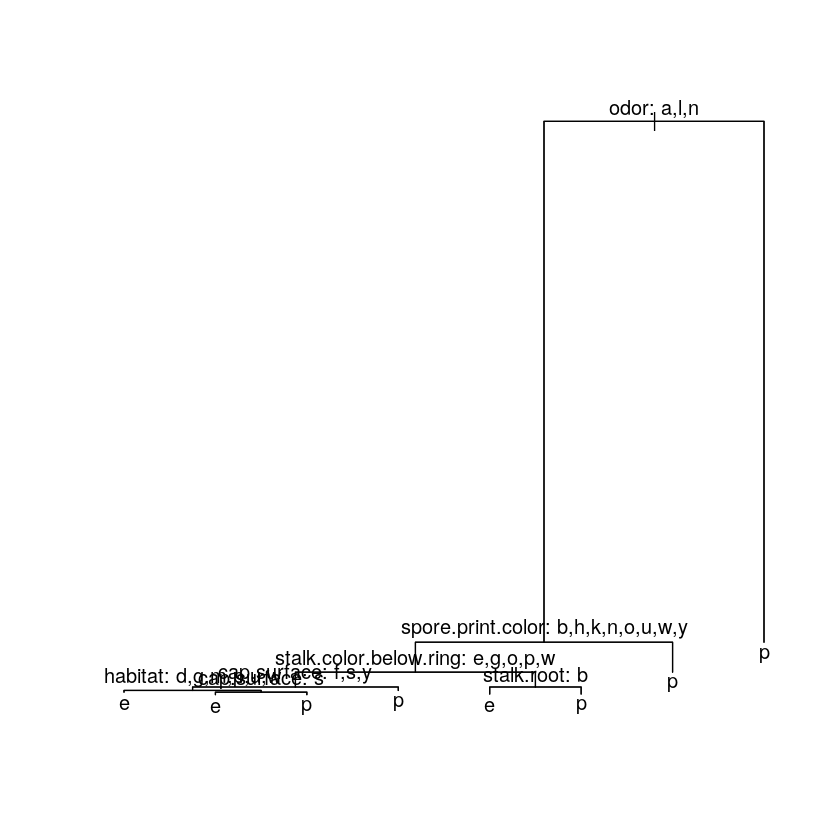

In [49]:
library(tree)

t.tree = tree(formula = class~.,data = mushrooms.train, mindev = 0, minsize = 2)
plot(t.tree)
text(t.tree, pretty = F)

t.tree$frame

pred.tree.train = predict(t.tree,  newdata = mushrooms.train, type = "class")
print("Accuracy medida en la muestra de entrenamiento:")
sum(diag(table(pred.tree.train, mushrooms.train$class))) / dim(mushrooms.train)[1]

pred.tree.test = predict(t.tree,  newdata = mushrooms.test, type = "class")
print("Accuracy medida en la muestra de test:")
sum(diag(table(pred.tree.test, mushrooms.test$class))) / dim(mushrooms.test)[1]

table(pred.tree.test, mushrooms.test$class)
table(pred.tree.train, mushrooms.train$class)

### Entrenamiento usando solo las dos variables más relevantes

Cuanto dicho se confirma aún más cuando los arboles se entrenan usando exclusivamente las dos variables con más poder de discriminación:
- odor;
- spore.print.color.

Se observa que quitar todas las demás variables tiene un efecto despreciable sobre el resultado final:
- la accuracy sigue siendo muy alta (95% - 99%);
- no se observa sobreajuste (o, dicho de otra manera, una diferencia en la accuracy en la muestra de test y en la muestra de entrenamiento).

#### Caret

odorn              odorf              odorl spore.print.colorn 
         1899,6657           582,4583           427,5720           394,0796 
spore.print.colork spore.print.colorh spore.print.colorr 
          384,6967           250,4498           147,1609

[1] "Accuracy medida en la muestra de entrenamiento:"


[1] 0,945183

[1] "Accuracy medida en la muestra de test:"


[1] 0,94387

                     
pred.caret.2.var.test   e   p
                    e 982  14
                    p 100 935

                      
pred.caret.2.var.train    e    p
                     e 2826   34
                     p  300 2933

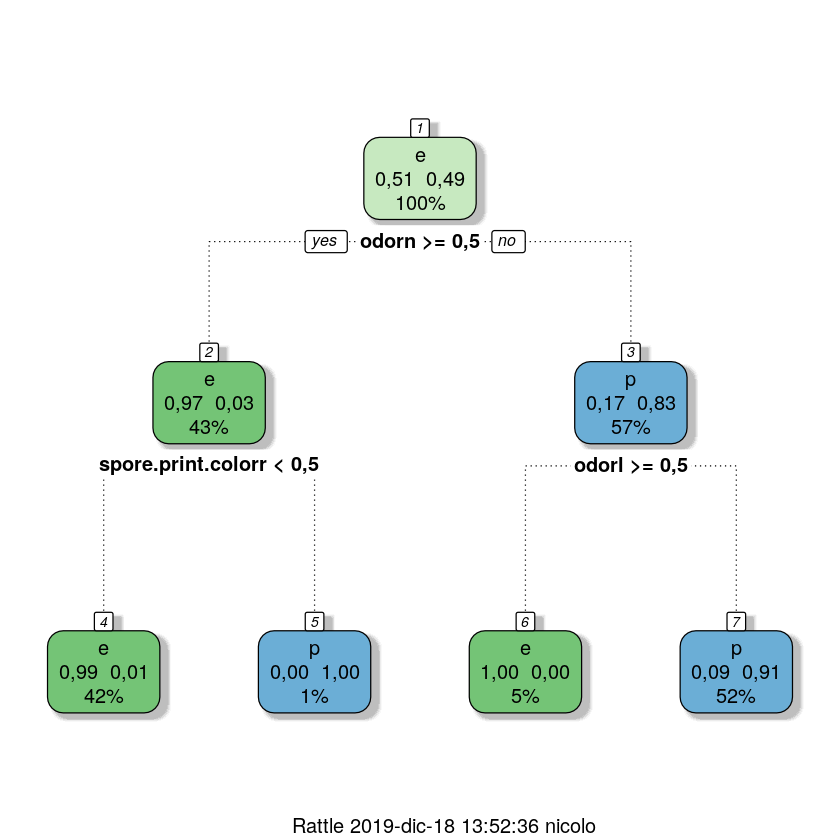

In [88]:
t.caret.2.var <- train(class ~ odor + spore.print.color, data = mushrooms.train, 
                 method = "rpart2")

fancyRpartPlot(t.caret.2.var$finalModel)

sort(t.caret.2.var$finalModel$variable.importance, decreasing = T)

pred.caret.2.var.train = predict(t.caret.2.var, newdata = mushrooms.train)
print("Accuracy medida en la muestra de entrenamiento:")
sum(diag(table(pred.caret.2.var.train, mushrooms.train$class))) / dim(mushrooms.train)[1]

pred.caret.2.var.test = predict(t.caret.2.var, newdata = mushrooms.test)
print("Accuracy medida en la muestra de test:")
sum(diag(table(pred.caret.2.var.test, mushrooms.test$class))) / dim(mushrooms.test)[1]

table(pred.caret.2.var.test, mushrooms.test$class)
table(pred.caret.2.var.train, mushrooms.train$class)

#### tree

[1] "Accuracy medida en la muestra de test:"


[1] 0,9931068

[1] "Accuracy medida en la muestra de entrenamiento:"


[1] 0,9944198

                    
pred.tree.2.var.test    e    p
                   e 1082   14
                   p    0  935

                     
pred.tree.2.var.train    e    p
                    e 3126   34
                    p    0 2933

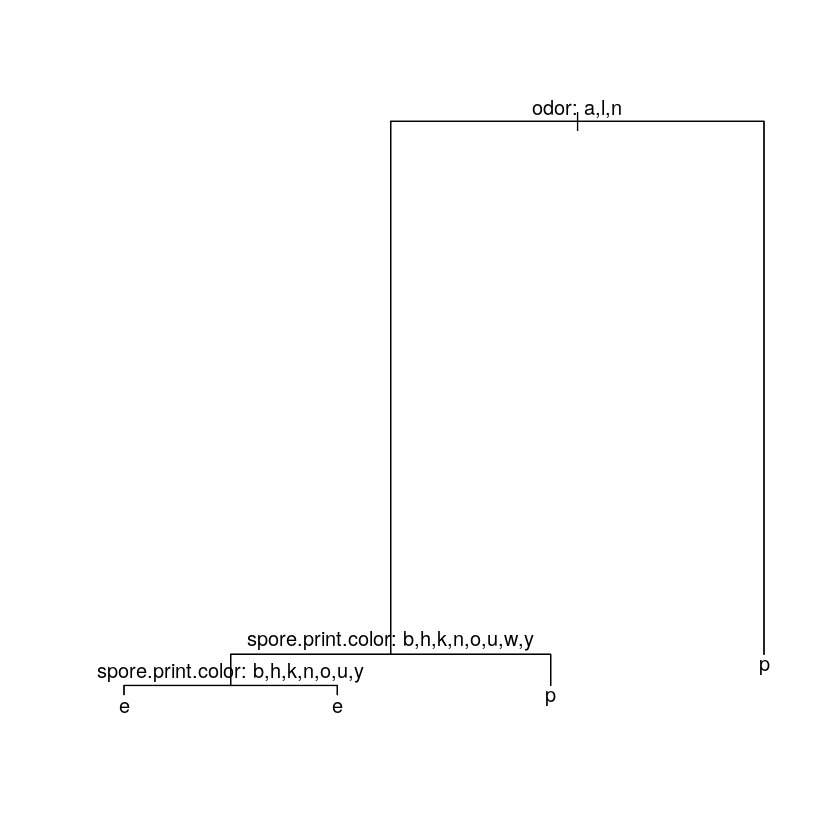

In [89]:
t.tree.2.var = tree(formula = class~ odor + spore.print.color,data = mushrooms.train, minsize = 2, mindev = 0)
plot(t.tree.2.var)
text(t.tree.2.var, pretty = F)

pred.tree.2.var.test = predict(t.tree.2.var,  newdata = mushrooms.test, type = "class")
print("Accuracy medida en la muestra de test:")
sum(diag(table(pred.tree.2.var.test, mushrooms.test$class))) / dim(mushrooms.test)[1]

pred.tree.2.var.train = predict(t.tree.2.var,  newdata = mushrooms.train, type = "class")
print("Accuracy medida en la muestra de entrenamiento:")
sum(diag(table(pred.tree.2.var.train, mushrooms.train$class))) / dim(mushrooms.train)[1]

table(pred.tree.2.var.test, mushrooms.test$class)
table(pred.tree.2.var.train, mushrooms.train$class)

### Entrenamiento usando dos variables que no sean las más relevantes

Las cosas cambian si intentamos quitar las dos variables principales del entrenamiento, obligando los arboles a intentar separar las dos categorias con otras caracteristicas de las setas. En este caso:
- gill.size;
- bruises.

Se observa como la accuracy baje hacia $\sim$ 75%, basicamente haciendo que sea mucho más peligroso comer una seta clasificada como comestible.

Esto se refleja en la matriz de confusión, que presenta ahora terminos fuera de la diagonal de tamaño comparable al de los elementos de la diagonal. En particular, estos elementos de la matriz de confusión representan las setas mal clasificadas:
- setas edibles clasificadas como venenosas (estamos tirando setas que podriamos comer);
- setas venenosas clasificadas como comestibles (estamos comiendo setas venenosas!).

Como última observación, seguimos viendo que no hay problemas de sobreajuste, ya que usando solo dos variables para el entrenamiento de los arboles, pueden crecer hasta una profundidad pequeña, y por lo tanto no hay un aprendizaje excesivo de la muestra de entrenamiento.

#### caret

note: only 2 possible values of the max tree depth from the initial fit.
 Truncating the grid to 2 .



gill.sizen   bruisest 
  870,9452   322,2278

[1] "Accuracy medida en la muestra de entrenamiento:"


[1] 0,7648121

[1] "Accuracy medida en la muestra de test:"


[1] 0,7641556

                           
pred.caret.2.other.var.test   e   p
                          e 677  74
                          p 405 875

                            
pred.caret.2.other.var.train    e    p
                           e 1979  286
                           p 1147 2681

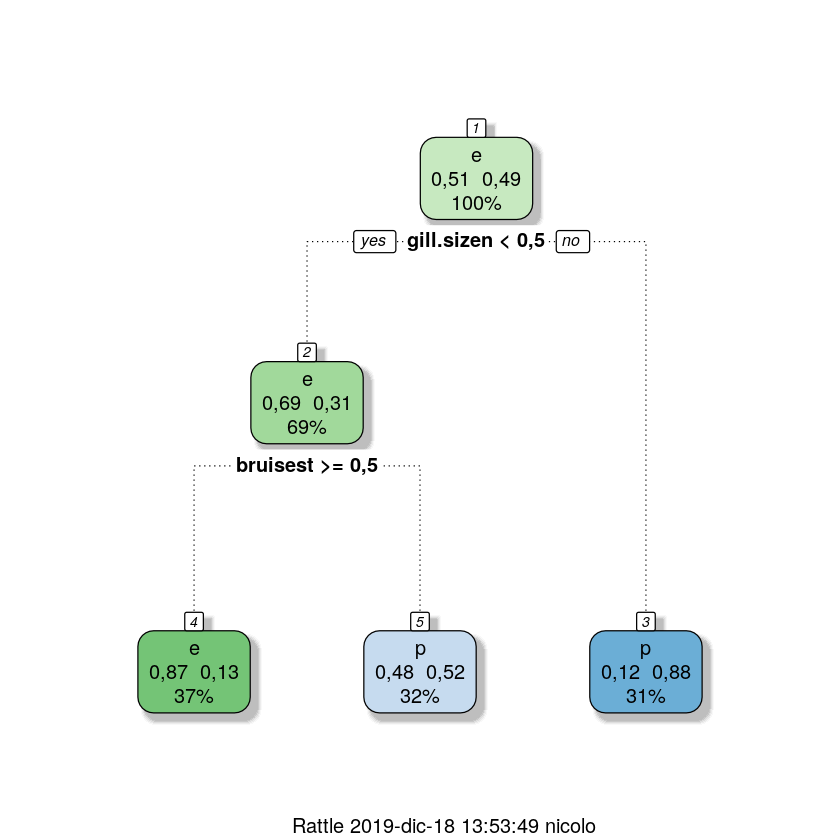

In [91]:
t.caret.2.other.var <- train(class ~ gill.size + bruises, data = mushrooms.train, 
                 method = "rpart2")

fancyRpartPlot(t.caret.2.other.var$finalModel)

sort(t.caret.2.other.var$finalModel$variable.importance, decreasing = T)

pred.caret.2.other.var.train = predict(t.caret.2.other.var, newdata = mushrooms.train)
print("Accuracy medida en la muestra de entrenamiento:")
sum(diag(table(pred.train.2.other.var, mushrooms.train$class))) / dim(mushrooms.train)[1]

pred.caret.2.other.var.test = predict(t.caret.2.other.var, newdata = mushrooms.test)
print("Accuracy medida en la muestra de test:")
sum(diag(table(pred.test.2.other.var, mushrooms.test$class))) / dim(mushrooms.test)[1]

table(pred.caret.2.other.var.test, mushrooms.test$class)
table(pred.caret.2.other.var.train, mushrooms.train$class)

#### tree


[1] "Accuracy medida en la muestra de entrenamiento:"


[1] 0,7648121

[1] "Accuracy medida en la muestra de test:"


[1] 0,7641556

                          
pred.tree.2.other.var.test   e   p
                         e 677  74
                         p 405 875

                           
pred.tree.2.other.var.train    e    p
                          e 1979  286
                          p 1147 2681

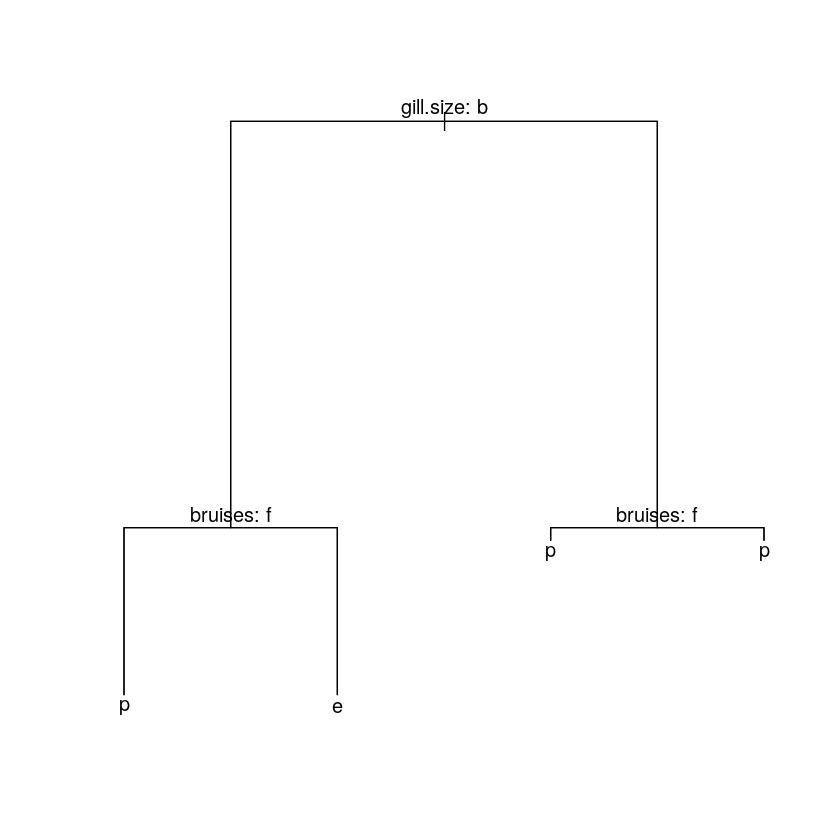

In [92]:
t.tree.2.other.var = tree(formula = class~ gill.size + bruises, data = mushrooms.train, minsize = 2, mindev = 0)
plot(t.tree.2.other.var)
text(t.tree.2.other.var, pretty = F)

pred.tree.2.other.var.train = predict(t.tree.2.other.var,  newdata = mushrooms.train, type = "class")
print("Accuracy medida en la muestra de entrenamiento:")
sum(diag(table(pred.tree.2.other.var.train, mushrooms.train$class))) / dim(mushrooms.train)[1]

pred.tree.2.other.var.test = predict(t.tree.2.other.var,  newdata = mushrooms.test, type = "class")
print("Accuracy medida en la muestra de test:")
sum(diag(table(pred.tree.2.other.var.test, mushrooms.test$class))) / dim(mushrooms.test)[1]

table(pred.tree.2.other.var.test, mushrooms.test$class)
table(pred.tree.2.other.var.train, mushrooms.train$class)

### Punto 3 (3 puntos):

Por un lado, las ramas del árbol pueden ser interpretadas como reglas de forma similar a las obtenidas por el algoritmo de reglas aplicado. Por ejemplo, en el caso del árbol obtenido con el dataset `Play Tennis` puede obtenerse las siguientes `reglas`: SI Outlook = Overcast -> Play Tennis = Yes ó SI (Outlook = Sunny) AND (Humidity = Normal) -> Play Tennis = Yes, cuya confianza asociada viene dada por la frecuencia relativa de cada caso en esa rama del árbol. Por otro lado, considerando las reglas que implican a nuestra variable objetivo tendríamos un `modelo` similar al dado por el árbol. Considerar y comparar ambas aproximaciones (p.e. ¿coinciden los antecedentes de las reglas? ¿alguna de las variables más frecuentes como antecedente en las reglas se corresponde con alguna de las variables con mayor capacidad de discriminación? etc.). 

## Desarrollo Punto 3

La analogia entre los arboles de decisión y las reglas de clasificación es evidente, y se hace aún más obvia cuando se representan las reglas a través de grafos, donde la flechas recuerdan los nodos y las ramas de los arboles que van hacia las hojas (o los consecuentes en e caso de las reglas).

Se puede observar también que la variable 'odor', que aparece como la más relevante en el caso de los arboles, es presente entre las reglas con soporte, confianza y lift más altos: en el caso de las setas venenosas como regla de un solo elemento (odor = foul --> class = poisonous), mientras que en el caso de las setas comestibles 'odor = none' es presente en todas las reglas seleccionadas como más significativas, representadas en el último grafo del punto (1).

Es también evidente como los arboles sean una herramienta más sencilla de manejar: como cada nodo de un arbol se define buscando la variable que proporciona la máxima perdida de entropia, nos ahorramos el proceso de generar todas las posible reglas (que pueden ser millones), la mayoría de las cuales redundantes, y de seleccionar las que presentan confianza, soporte y lift más alto.

Por otro lado, los arboles requieren más cuidado, ya que son más susceptibles a sobreajuste: en la fase de entrenamiento, si esa se hace sin tener cuidado, el árbol puede acabar aprendiendo los detalles de la muestra de entrenamiento, también los que son debidos a fluctuaciones estdisticas, haciendo que el árbol no se pueda usar para hacer predicciones sobre otro dataset.

Para obviar a ese problema, se utiliza la validación cruzada, gracias a la cual es posible verificar si el arbol entrenado proporciona reglas aplicables a otros datasets, o si está sobreajustado a la muestra de entrenamiento.
Para eso, parte de la muestra de entrenamiento (llamada muestra de test) se deja sin utilizar en la fase de crecimiento del árbol. Esto significa que el árbol no conoce los eventos de la muestra de test: se puede entonces utilizar el arbol sobre la muestra de test para verificar si sus reglas logran clasificar correctamente los eventos de la muestra de test. 

Si las tasas de acierto y de fallo en la muestra de test son parecidas a las obtenidas en la muestra de entrenamiento, el arbol está proporcionando reglas generales, mientras que si las tasas de acierto son más grandes en la muestra de entrenamiento que en la muestra de test, el arbol se ha sobreajustado, y no es capaz de predecir correctamente.

Es necesario entonces 'podar' el árbol, removiendo algunas de las hojas que dan información válida exclusivamente para la muestra de entrenamiento, pero no en general. 